In [1]:
!pip install torchinfo

# Import Libraries


In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
import seaborn as sns

# Configuration

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


# Variables

In [4]:
# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 30
IMG_SIZE = 224
PATIENCE = 5  # Early stopping patience

# Paths
# Adjust this based on your exact folder structure
ROOT_DIR = "/kaggle/input/project-dataset/Betel Leaf Image Dataset from Bangladesh"
OUTPUT_DIR = "/kaggle/working/"

# Handle potential subfolder structure
if os.path.exists(os.path.join(ROOT_DIR, "Original Images")):
    DATA_DIR = os.path.join(ROOT_DIR, "Original Images")
else:
    DATA_DIR = ROOT_DIR

print(f"Data Directory: {DATA_DIR}")

Data Directory: /kaggle/input/project-dataset/Betel Leaf Image Dataset from Bangladesh/Original Images


# Explore Dataset

Total Images: 1000
Classes: ['Bacterial Leaf Disease', 'Dried Leaf', 'Fungal Brown Spot Disease', 'Healthy Leaf']


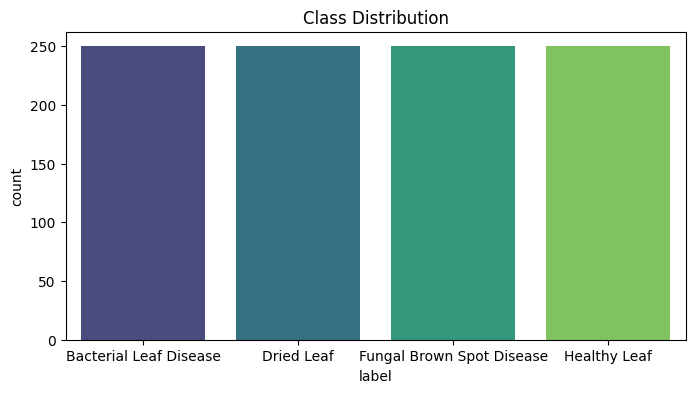

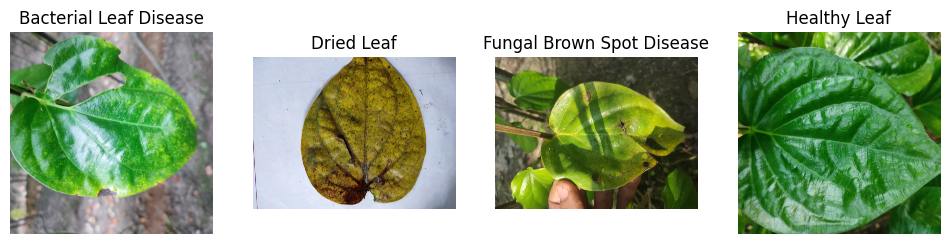

In [5]:
def load_data(dir_path):
    filepaths = []
    labels = []
    classes = sorted(os.listdir(dir_path))
    
    for class_name in classes:
        class_path = os.path.join(dir_path, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    filepaths.append(os.path.join(class_path, file))
                    labels.append(class_name)
    return pd.DataFrame({'filepath': filepaths, 'label': labels}), classes

# Load Data
df, class_names = load_data(DATA_DIR)
num_classes = len(class_names)
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

print(f"Total Images: {len(df)}")
print(f"Classes: {class_names}")

# Visualization
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Class Distribution")
plt.show()

# Show Sample Images
plt.figure(figsize=(12, 4))
for i, c in enumerate(class_names):
    path = df[df['label'] == c].iloc[0]['filepath']
    img = Image.open(path)
    plt.subplot(1, len(class_names), i+1)
    plt.imshow(img)
    plt.title(c)
    plt.axis('off')
plt.show()

# Data Preprocessing 

In [6]:
# 70% Train, 30% Temp
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=42
)

# Split Temp into 50% Val (15% total) and 50% Test (15% total)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42
)

print(f"Training Set: {len(train_df)}")
print(f"Validation Set: {len(val_df)}")
print(f"Testing Set: {len(test_df)}")


Training Set: 700
Validation Set: 150
Testing Set: 150


Dataset Split Ratios
Train: 700 images (70.00%)
Test: 150 images (15.00%)
Validation: 150 images (15.00%)


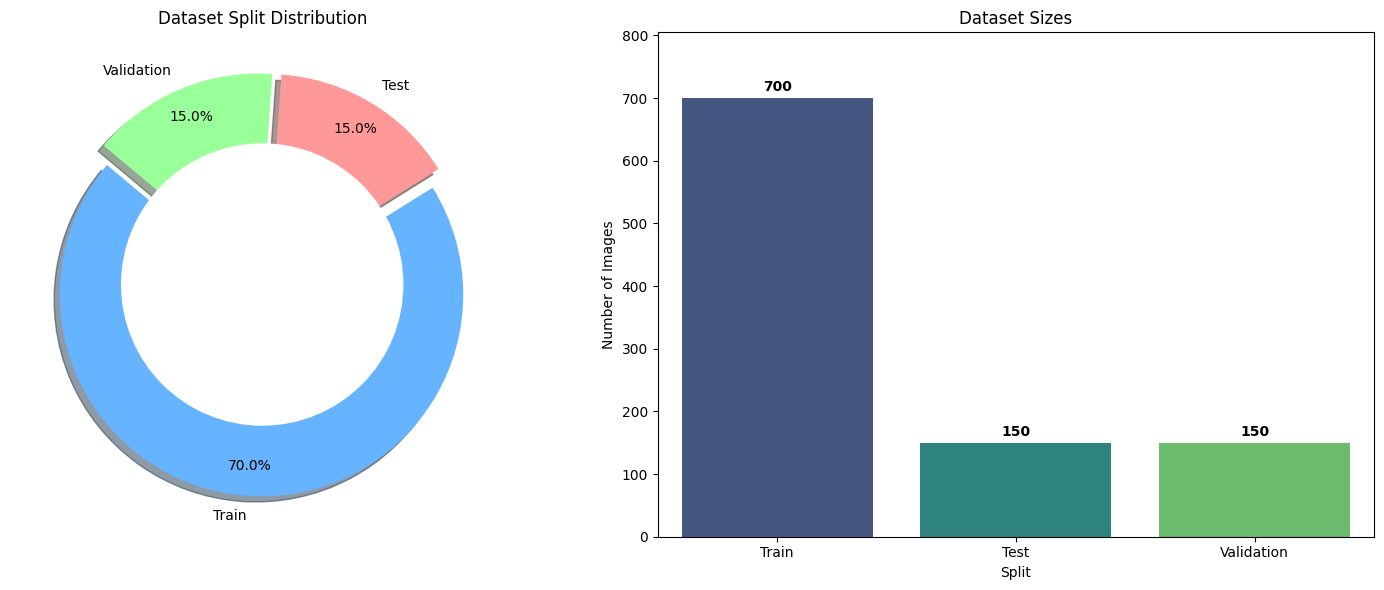

In [7]:
train_df, temp_df = train_test_split(
    df, 
    test_size=0.30, 
    stratify=df['label'], 
    random_state=42
)

# Second Split: Separate Temp into Validation (15%) and Test (15%)
# Since Temp is 30% of total, splitting it by 0.5 gives 15% each.
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    stratify=temp_df['label'], 
    random_state=42
)

# ==========================================
# 2. Text Output
# ==========================================
n_total = len(df)
n_train = len(train_df)
n_test = len(test_df)
n_val = len(val_df)

print("Dataset Split Ratios")
print(f"Train: {n_train} images ({n_train/n_total*100:.2f}%)")
print(f"Test: {n_test} images ({n_test/n_total*100:.2f}%)")
print(f"Validation: {n_val} images ({n_val/n_total*100:.2f}%)")

# ==========================================
# 3. Visualization (Pie & Bar Charts)
# ==========================================
plt.figure(figsize=(15, 6))

# --- Pie Chart (Distribution) ---
plt.subplot(1, 2, 1)
sizes = [n_train, n_test, n_val]
labels = ['Train', 'Test', 'Validation']
colors = ['#66b3ff', '#ff9999', '#99ff99'] # Blue, Red, Green pastel
explode = (0.05, 0.05, 0.05)  # Slightly separate slices

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=140, pctdistance=0.85, explode=explode, shadow=True)

# Add a white circle in the center for a "Donut" style (optional, looks cleaner)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Dataset Split Distribution')

# --- Bar Chart (Dataset Sizes) ---
plt.subplot(1, 2, 2)
# Create DataFrame for plotting
split_data = pd.DataFrame({
    'Split': ['Train', 'Test', 'Validation'],
    'Count': [n_train, n_test, n_val]
})

ax = sns.barplot(x='Split', y='Count', data=split_data, palette='viridis')

# Add number annotations on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 8), 
                textcoords='offset points',
                fontweight='bold')

plt.title('Dataset Sizes')
plt.ylabel('Number of Images')
plt.ylim(0, n_train * 1.15) # Add space at top for labels

plt.tight_layout()
plt.show()

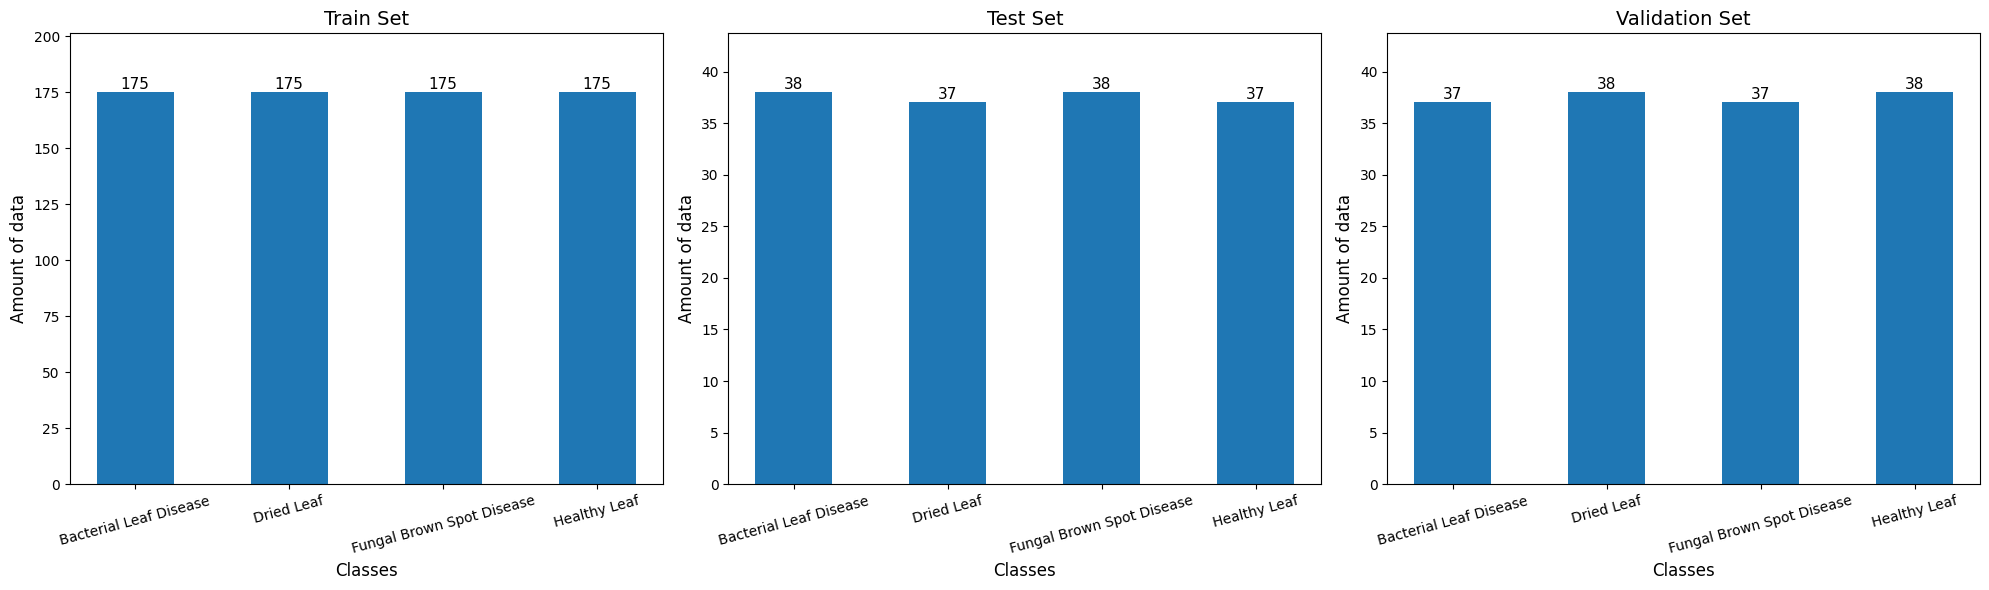

In [8]:
train_df, temp_df = train_test_split(
    df, 
    test_size=0.30, 
    stratify=df['label'], 
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    stratify=temp_df['label'], 
    random_state=42
)

# ==========================================
# 2. Plotting Function to Match Sample Output
# ==========================================
def plot_split_distribution(dfs, titles):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Iterate through Train, Test, Validation
    for i, (data, title) in enumerate(zip(dfs, titles)):
        ax = axes[i]
        
        # Count images per class
        class_counts = data['label'].value_counts().sort_index()
        x_labels = class_counts.index
        y_values = class_counts.values
        
        # Create Bar Plot
        # width=0.5 makes the bars thinner like your sample image
        bars = ax.bar(x_labels, y_values, width=0.5, color='#1f77b4') 
        
        # Styling
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Classes', fontsize=12)
        ax.set_ylabel('Amount of data', fontsize=12)
        
        # Add Count Annotations on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.,  # X center
                height,                              # Y height
                f'{int(height)}',                    # Text
                ha='center', va='bottom', fontsize=11
            )
        
        # Set Y-limit with some headroom for the text
        ax.set_ylim(0, max(y_values) * 1.15)
        
        # Rotate x-labels if class names are long
        ax.tick_params(axis='x', rotation=15)

    plt.tight_layout()
    plt.show()

# ==========================================
# 3. Execution
# ==========================================
datasets = [train_df, test_df, val_df]
titles = ["Train Set", "Test Set", "Validation Set"]

plot_split_distribution(datasets, titles)

In [9]:
# 1. Get the path of the first image in the training set
# Note: We use 'train_df' and 'filepath' based on the previous steps.
# If you named your variable 'train_dataframe', replace 'train_df' with that.
sample_image_path = train_df['filepath'].iloc[0]

# 2. Open the image using PIL
img = Image.open(sample_image_path)

# 3. Get the bands (channels)
# .getbands() returns a tuple like ('R', 'G', 'B')
bands = img.getbands()
num_channels = len(bands)

# 4. Print the result
print(f"Number of channels: {num_channels}")

Number of channels: 3


# Dataset Class, Data Transform and Dataloader

In [10]:
class BetelLeafDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['filepath']).convert('RGB')
        label = class_to_idx[row['label']]
        
        if self.transform:
            img = self.transform(img)
            
        return img, torch.tensor(label, dtype=torch.long)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# DataLoaders
train_loader = DataLoader(BetelLeafDataset(train_df, train_transform), 
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(BetelLeafDataset(val_df, val_test_transform), 
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(BetelLeafDataset(test_df, val_test_transform), 
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Deep Learning Model

In [11]:
# 1. Define the Computation Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Define the CustomCNN Architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 112x112
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 56x56
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 28x28
            
            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 14x14
            
            # Block 5 (Deeper architecture as per your previous request)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 7x7
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 3. Initialize the Model
# Ensure num_classes is defined (usually 4 for this dataset)
num_classes = 4 

model = CustomCNN(num_classes=num_classes).to(device)
print("Model initialized successfully on:", device)
print(model)

Using device: cuda
Model initialized successfully on: cuda
CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=

# Model Training

Starting Training...


Epoch 1: Train Loss=1.1315 Acc=60.43% | Val Loss=0.7220 Acc=62.67%


Epoch 2: Train Loss=0.5051 Acc=78.57% | Val Loss=0.3258 Acc=85.33%


Epoch 3: Train Loss=0.4075 Acc=84.00% | Val Loss=0.2224 Acc=92.00%


Epoch 4: Train Loss=0.3540 Acc=85.71% | Val Loss=0.2414 Acc=91.33%


Epoch 5: Train Loss=0.3087 Acc=86.57% | Val Loss=0.2391 Acc=91.33%


Epoch 6: Train Loss=0.3230 Acc=86.71% | Val Loss=0.1921 Acc=92.67%


Epoch 7: Train Loss=0.2620 Acc=88.86% | Val Loss=0.1834 Acc=92.00%


Epoch 8: Train Loss=0.2531 Acc=90.00% | Val Loss=0.1869 Acc=90.67%


Epoch 9: Train Loss=0.3048 Acc=88.86% | Val Loss=0.2061 Acc=92.00%


Epoch 10: Train Loss=0.2641 Acc=88.29% | Val Loss=0.1975 Acc=92.67%


Epoch 11: Train Loss=0.3306 Acc=87.57% | Val Loss=0.3064 Acc=85.33%


Epoch 12: Train Loss=0.2959 Acc=87.14% | Val Loss=0.1928 Acc=90.00%
Early Stopping Triggered.


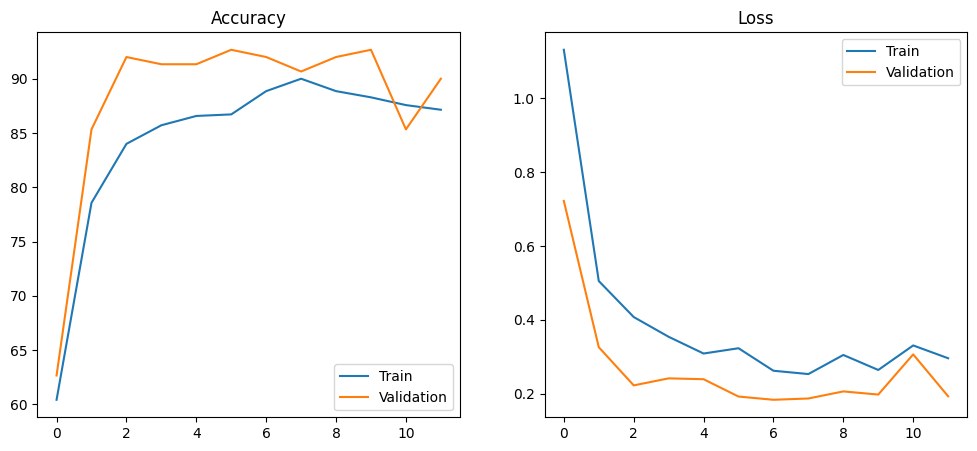

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting Training...")

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = 100 * correct / total
    
    # --- VALIDATION ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = 100 * val_correct / val_total
    
    # Logs
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)
    
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} Acc={avg_train_acc:.2f}% | Val Loss={avg_val_loss:.4f} Acc={avg_val_acc:.2f}%")
    
    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pth'))
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early Stopping Triggered.")
            break

# Plotting Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()



# Load Saved Checkpoints

In [13]:
# Load best model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth')))
model.eval()
print("Best model weights loaded.")

Best model weights loaded.


# ROC curve 

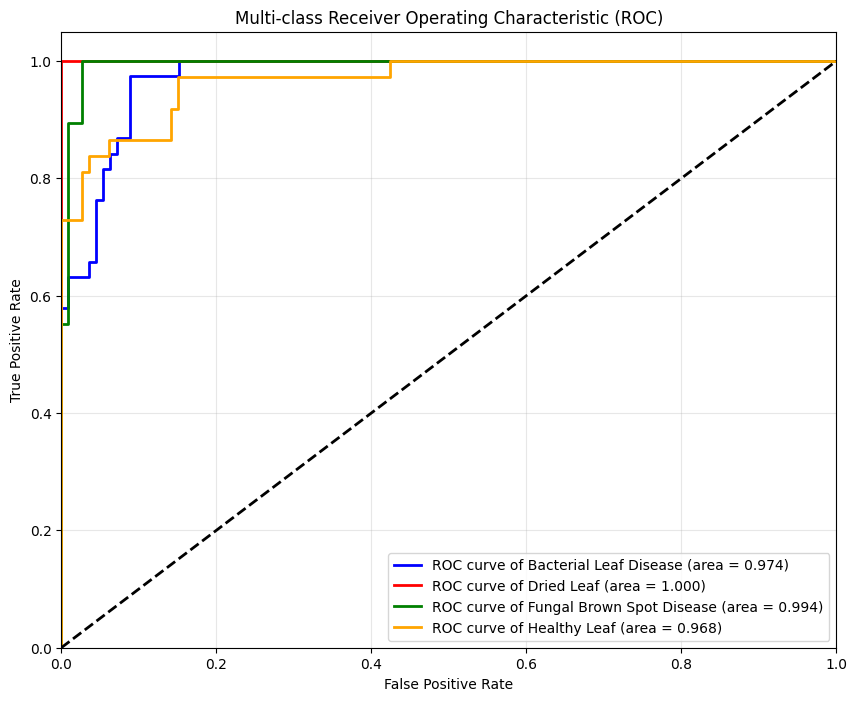

In [14]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_multiclass_roc(model, test_loader, num_classes, class_names):
    # 1. Get Model Predictions (Probabilities)
    y_true = []
    y_scores = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Apply Softmax to get probabilities (0 to 1 range)
            probs = F.softmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())
            
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # 2. Binarize the labels (One-hot encoding for One-vs-Rest)
    # e.g., Class 0 becomes [1, 0, 0, 0]
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    
    # 3. Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # 4. Plotting
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.3f})')
    
    # Plot Diagonal (Random Guessing)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Run the function
# class_names should be defined from your earlier "Explore Dataset" step
plot_multiclass_roc(model, test_loader, num_classes=4, class_names=class_names)

# Evaluation

In [15]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [16]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

# 2. Start Timer
start_time = time.time()

# 3. Evaluation Loop
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 4. Stop Timer
end_time = time.time()
test_time = end_time - start_time

# 5. Calculate Metrics
test_accuracy = correct / total

# 6. Print Output
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.893
Test Time: 18.62 seconds ---> 0.31 minutes


Classification Report:

                           precision    recall  f1-score   support

   Bacterial Leaf Disease       0.83      0.79      0.81        38
               Dried Leaf       0.97      1.00      0.99        37
Fungal Brown Spot Disease       0.92      0.95      0.94        38
             Healthy Leaf       0.84      0.84      0.84        37

                 accuracy                           0.89       150
                macro avg       0.89      0.89      0.89       150
             weighted avg       0.89      0.89      0.89       150



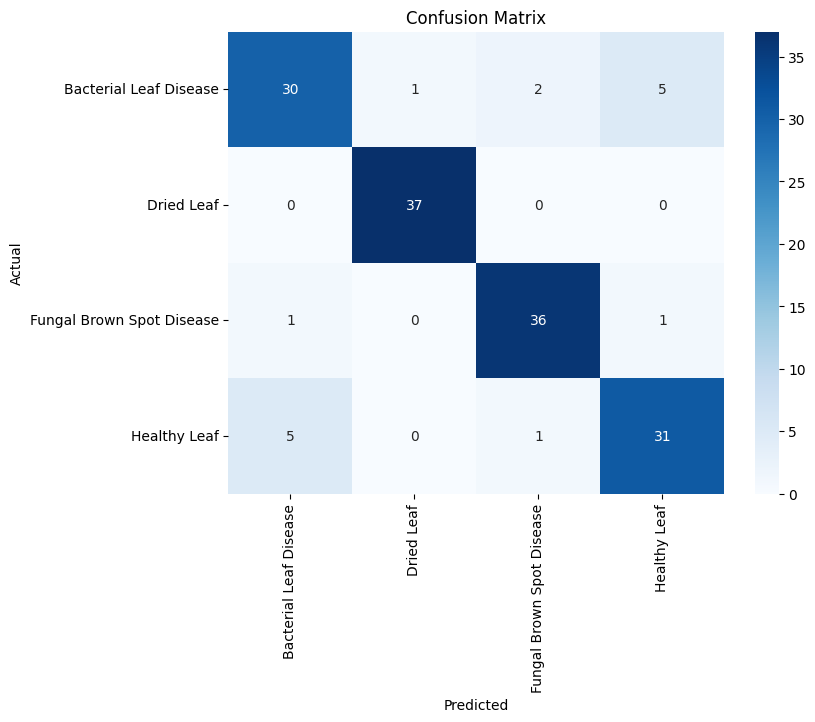

In [17]:
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# --- Calculate Per-Class Accuracy ---
def get_class_accuracy(model, dataloader, num_classes):
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Compare predictions to ground truth
            c = (predicted == labels).squeeze()
            
            # Iterate through the batch
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    return class_correct, class_total

# Get the counts
class_correct, class_total = get_class_accuracy(model, test_loader, num_classes)

# Print Output in requested format
print("Per-Class Accuracy Results:")
print("-" * 30)
for i in range(num_classes):
    # Avoid division by zero
    if class_total[i] > 0:
        acc = class_correct[i] / class_total[i]
    else:
        acc = 0.0
    
    # Print: Class X Accuracy: 0.XXX
    # We also show the actual Class Name (e.g., Healthy) for clarity
    print(f"Class {i} ({class_names[i]}) Accuracy: {acc:.3f}")
print("-" * 30)

Per-Class Accuracy Results:
------------------------------
Class 0 (Bacterial Leaf Disease) Accuracy: 0.789
Class 1 (Dried Leaf) Accuracy: 1.000
Class 2 (Fungal Brown Spot Disease) Accuracy: 0.947
Class 3 (Healthy Leaf) Accuracy: 0.838
------------------------------


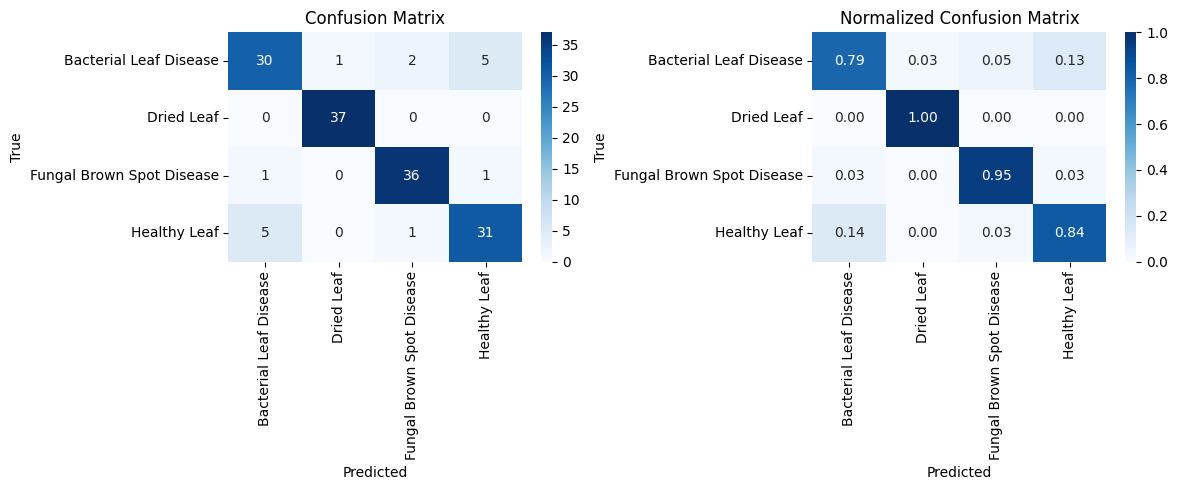

In [19]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Explainable AI (GradCAM)

Visualizing GradCAM for classes: ['Bacterial Leaf Disease', 'Dried Leaf', 'Fungal Brown Spot Disease', 'Healthy Leaf']
Targeting Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


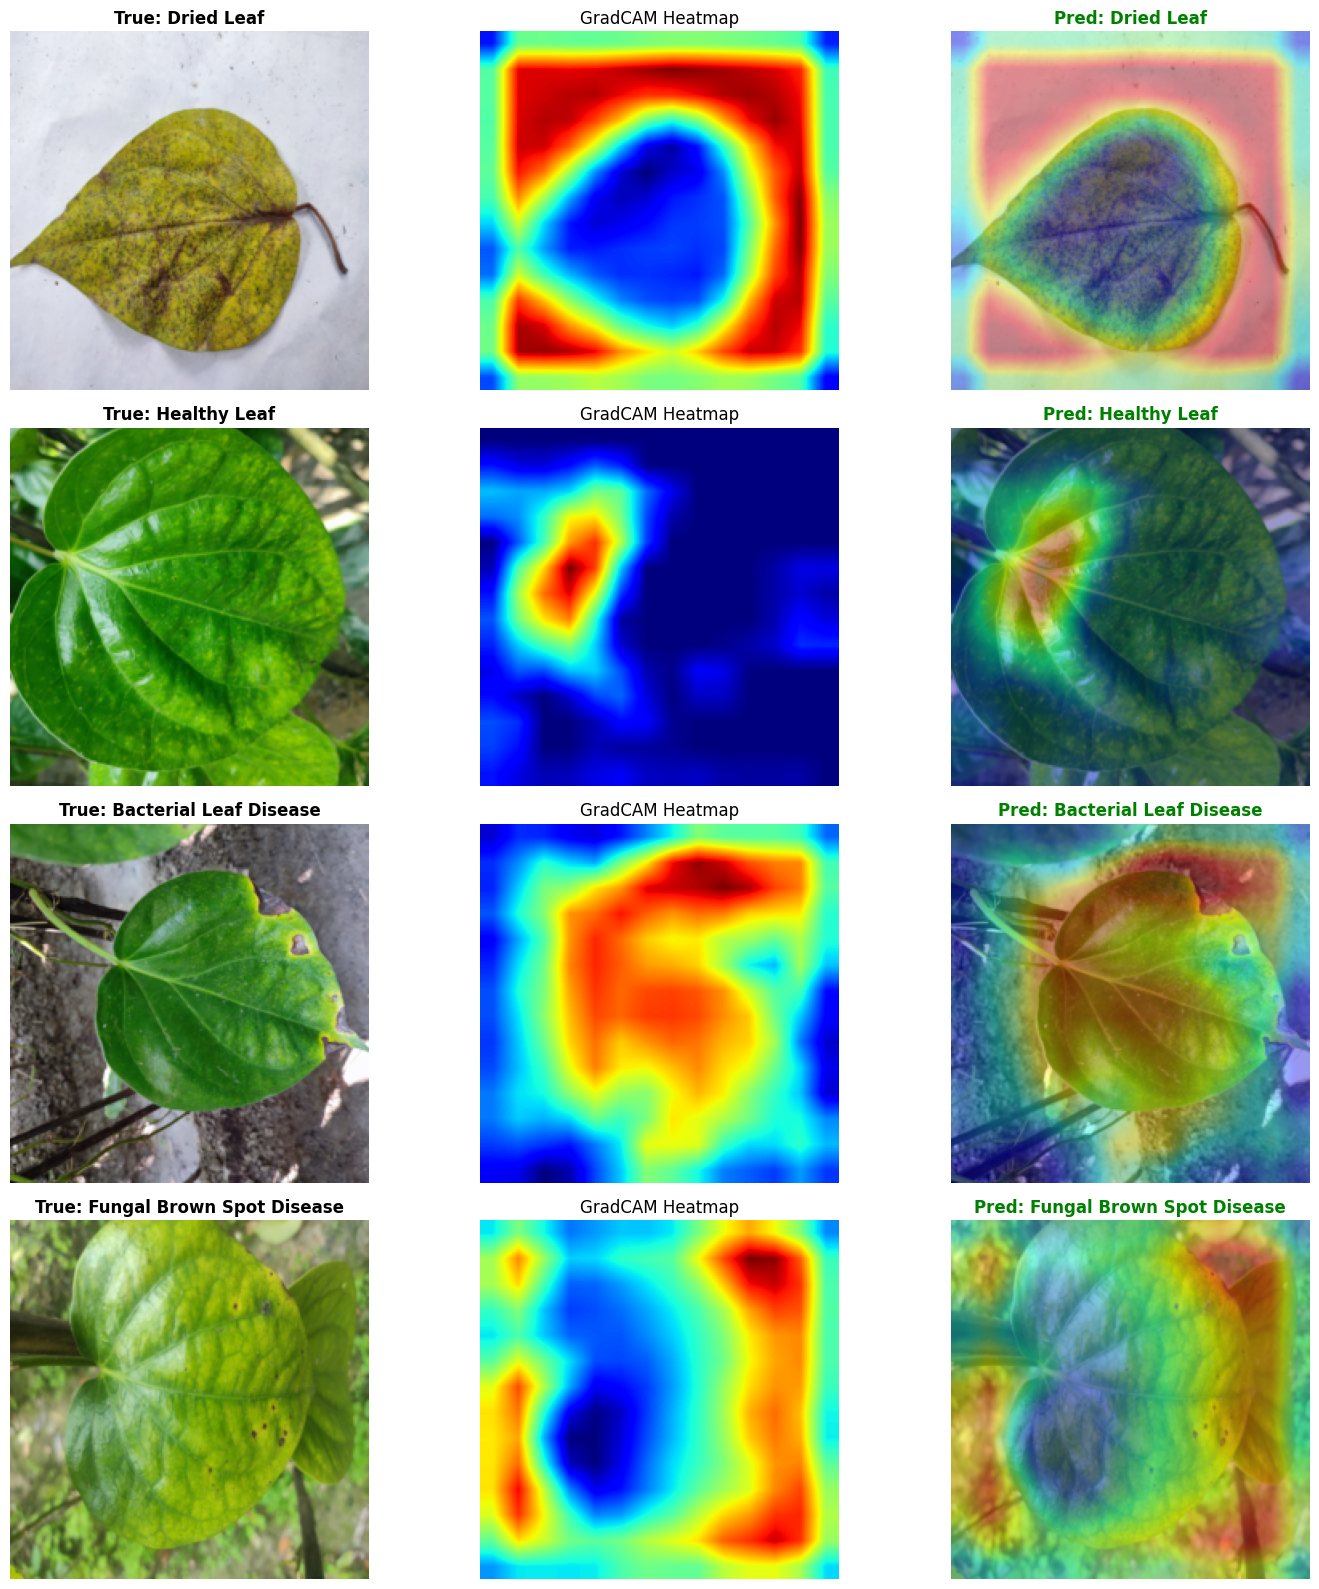

In [20]:
# ==========================================
# 1. GradCAM Class Definition
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Use register_full_backward_hook for modern PyTorch
        handle_f = self.target_layer.register_forward_hook(forward_hook)
        handle_b = self.target_layer.register_full_backward_hook(backward_hook)
        self.hook_handles = [handle_f, handle_b]

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()
        
        # Forward pass
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
            
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        score = output[:, target_class]
        score.backward()
        
        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        # Global Average Pooling of gradients (weights)
        weights = np.mean(gradients, axis=(1, 2))
        
        # Weighted sum
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
            
        # ReLU
        cam = np.maximum(cam, 0)
        
        # Resize to 224x224
        cam = cv2.resize(cam, (224, 224))
        
        # Normalize
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)
        
        return cam, target_class

# ==========================================
# 2. Visualization Helper
# ==========================================
def denormalize_image(tensor_img):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(tensor_img)
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    return img

def visualize_gradcam(model, loader, target_layer, class_names):
    grad_cam = GradCAM(model, target_layer)
    
    found_classes = set()
    examples = []
    
    # Iterate through loader to find 1 example per class
    data_iter = iter(loader)
    while len(found_classes) < len(class_names):
        try:
            images, labels = next(data_iter)
        except StopIteration:
            break
            
        for i in range(len(labels)):
            label_idx = labels[i].item()
            if label_idx not in found_classes:
                found_classes.add(label_idx)
                examples.append((images[i], label_idx))
                
            if len(found_classes) >= len(class_names):
                break
    
    # Plot results
    plt.figure(figsize=(15, 4 * len(examples)))
    
    for i, (img_tensor, label_idx) in enumerate(examples):
        input_tensor = img_tensor.unsqueeze(0).to(device)
        
        # Generate Heatmap
        heatmap, pred_idx = grad_cam.generate_cam(input_tensor, target_class=label_idx)
        
        # Process images for display
        original_img = denormalize_image(img_tensor)
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
        overlay = 0.6 * original_img + 0.4 * heatmap_colored
        
        true_name = class_names[label_idx]
        pred_name = class_names[pred_idx]
        color = 'green' if true_name == pred_name else 'red'
        
        # Subplots
        plt.subplot(len(examples), 3, 3*i + 1)
        plt.imshow(original_img)
        plt.title(f"True: {true_name}", fontweight='bold')
        plt.axis('off')
        
        plt.subplot(len(examples), 3, 3*i + 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("GradCAM Heatmap")
        plt.axis('off')
        
        plt.subplot(len(examples), 3, 3*i + 3)
        plt.imshow(overlay)
        plt.title(f"Pred: {pred_name}", color=color, fontweight='bold')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    
    grad_cam.remove_hooks()

# ==========================================
# 3. Execution (Corrected)
# ==========================================
# Access the last convolutional layer via indices.
# Structure: [... Conv2d, BatchNorm, ReLU, MaxPool]
# MaxPool is -1, ReLU is -2, BN is -3, Conv2d is -4.
target_layer = model.features[-4]

print(f"Visualizing GradCAM for classes: {class_names}")
print(f"Targeting Layer: {target_layer}")

visualize_gradcam(model, test_loader, target_layer, class_names)